# Making bets on NBA games using Bayesian Neural Networks
The goal of this notebook is to explore the use of Bayesian Neural Networks (BNNs) in predicting the outcome of NBA games. While using MLPs as seen in ```mlp_betting.ipynb``` may be computationally more efficient, personal testing has shown that tradional neural networks are overconfident in predictions making them unsuitable for betting. By learning the distributions of weights, BNNs can hopefully provide a better estimate on the outcome of games for use in betting.

To test betting capability, we will use historic betting data gathered from vegasinsider.com to determine the money made from each model's predictions. The goal of the model is not to maximize accuracy (as NBA games are incredibly stochastic), but instead to maximize performance relative to odds set by Vegas. The algorithm for placing bets will be a modified version of the [kelly critereon](https://en.wikipedia.org/wiki/Kelly_criterion) betting strategy, defined in the functions ```kelly``` and ```BNN_kelly``` found in **util/client.py**.

NOTE: The most recent and relevant exploration in this notebook is being done in the [**Using consecutive games stats**](#Using-consecutive-game-stats) section. Previous sections use old data, which is based on end of year totals for each team. More detail on how these datasets differ is available in the afformentioned section.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate,cross_val_predict
from sklearn.metrics import classification_report,confusion_matrix,make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from util.client import Nba_Season, kelly, BNN_kelly, make_bets, pred_performance
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.nn import PyroModule, PyroSample
import torch
import torch.nn as nn
from torch.nn import Softmax
from pyro.infer import MCMC, NUTS
from pyro.infer import Predictive

## Define simple BNN using Pyro containing 1 hidden layer

For this implementation, we will be using the [Pyro Probablistic Programming language](https://github.com/pyro-ppl/pyro), loosely following a [tutorial](https://colab.research.google.com/drive/1NQNMdKaE9RncuWgO_vM2k3qywV76Byfh) from the University of Amsterdam

Currently, the model will only be predicting the outcomes of games (home win or away win) and compare outcomes to moneyline odds from [vegas insider](https://www.vegasinsider.com/nba/odds/las-vegas/). Because of this, the model will be learning a categorical output, 0 indicating a home win and 1 indicating away win. The model will sample each layers weights and biases from a normal distribution while the prediction will be sampled from a categorical distribution based on the output of the layers.

In [2]:
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=5, prior_scale=1.):
        super().__init__()

        self.activation = nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([in_dim, hid_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim,]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, out_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim,]).to_event(1)) # output bias term

    def forward(self, x, y=None):
        z1 = self.activation(x @ self.layer1.weight + self.layer1.bias) # pass thru first layer
        z2 = self.activation(z1 @ self.layer2.weight + self.layer2.bias) # pass thru output layer

        #, x.shape[0]
        with pyro.plate("data"):
            y_hat = Softmax(dim=1)(z2) # scale output via softmax for setting categorical priors
            # y_hat = Softmax(dim=0)(x)
            obs = pyro.sample("obs", dist.Categorical(y_hat), obs=y)

        return z2

In [66]:
# load old samples and features
features = np.genfromtxt('../NBA/total/samps_feats/2015-2023_nba_features_norm_inj.csv',delimiter=',')
samples = np.genfromtxt('../NBA/total/samps_feats/2015-2023_nba_samples_inj.csv',delimiter=',')
samples_1d = [0 if j[0] == 0 else 1 for j in samples]
feat_train, feat_test, samp_train, samp_test = train_test_split(features, samples, test_size=0.25, random_state=1)
x_train = torch.FloatTensor(feat_train)
x_test = torch.FloatTensor(feat_test)
y_train = torch.FloatTensor(samp_train)
y_test = torch.FloatTensor(samp_test)

model = BNN(in_dim=16,hid_dim=16,out_dim=2)

pyro.set_rng_seed(1)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

mcmc.run(x_train, y_train.T)

Warmup:   0%|          | 0/100 [00:00, ?it/s]

Sample: 100%|██████████| 100/100 [07:31,  4.51s/it, step size=1.17e-02, acc. prob=0.450]


In [81]:
# get predictions based on posteriors
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples(), return_sites=['obs','_RETURN'])

train_preds = predictive(x_train)['obs'].T.float().mean(axis=1) # each x in training produces 50 predictions (0 or 1), take average
test_preds = predictive(x_test)['obs'].T.float().mean(axis=1)

adj_train_preds = [0 if p < 0.5 else 1 for p in train_preds]
adj_test_preds = [0 if p < 0.5 else 1 for p in test_preds]
y_train_1d = [0 if j[0] == 0 else 1 for j in y_train] # [0,1] -> [away,home] -> 0 indicates home win, 1 indicates away
y_test_1d = [0 if j[0] == 0 else 1 for j in y_test]

print('---TRAINING SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_train_1d,adj_train_preds).ravel())
print(classification_report(y_train_1d,adj_train_preds))
print('---TEST SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_test_1d,adj_test_preds).ravel())
print(classification_report(y_test_1d,adj_test_preds))

---TRAINING SET---
TN, FP, FN, TP
[1969 2431 1894 2343]
              precision    recall  f1-score   support

           0       0.51      0.45      0.48      4400
           1       0.49      0.55      0.52      4237

    accuracy                           0.50      8637
   macro avg       0.50      0.50      0.50      8637
weighted avg       0.50      0.50      0.50      8637

---TEST SET---
TN, FP, FN, TP
[678 813 596 793]
              precision    recall  f1-score   support

           0       0.53      0.45      0.49      1491
           1       0.49      0.57      0.53      1389

    accuracy                           0.51      2880
   macro avg       0.51      0.51      0.51      2880
weighted avg       0.51      0.51      0.51      2880



Place bets using `BNN_Kelly` on 2022-2023 and 2023-2024 seasons

In [79]:
# Get 2022-2023 game data and betting information
features_new = np.genfromtxt('../NBA/total/samps_feats/2022-2023_nba_features_inj.csv',delimiter=',')
samples_new = np.genfromtxt('../NBA/total/samps_feats/2022-2023_nba_samples_inj.csv',delimiter=',')
bet_data = np.genfromtxt('../NBA/with_bets/2022-2023_season.csv',delimiter=',')

samples_new_1d = [0 if j[0] == 0 else 1 for j in samples_new]

new_x_tens = torch.FloatTensor(features_new)
new_y_tens = torch.FloatTensor(samples_new)

new_predictive = Predictive(model=model, posterior_samples=mcmc.get_samples(),return_sites=("obs","_RETURN"))
new_y_pred = new_predictive(new_x_tens)['obs'].T.float().mean(axis=1)

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,samples_new_1d,bet_data[1:])

print(correct)
print(guessed)
print(sum(gained))

48
104
tensor(-465.6457)


In [82]:
# Test on 2023-2024 data
features_new = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_features_inj.csv',delimiter=',')
samples_new = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_samples_inj.csv',delimiter=',')
bet_data = np.genfromtxt('../NBA/with_bets/2023-2024_season.csv',delimiter=',')

samples_new_1d = [0 if j[0] == 0 else 1 for j in samples_new]

new_x_tens = torch.FloatTensor(features_new)
new_y_tens = torch.FloatTensor(samples_new)

new_predictive = Predictive(model=model, posterior_samples=mcmc.get_samples(),return_sites=("obs","_RETURN"))
new_y_pred = new_predictive(new_x_tens)['obs'].T.float().mean(axis=1)

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,samples_new_1d,bet_data[1:])

print(correct)
print(guessed)
print(sum(gained))

22
56
tensor(-331.8321)


### Initial testing yielded better results than traditional MLPs as seen in ``mlp_betting.ipynb``, explore BNN architecture with more layers
Add a single hidden layer to our existing architecture and increase the number of posterior samples used during MCMC training

In [3]:
class BNN_Multi_Layer(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, first_hid_dim=5, sec_hid_dim=5, prior_scale=1.):
        super().__init__()

        self.activation = nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, first_hid_dim)
        self.layer2 = PyroModule[nn.Linear](first_hid_dim, sec_hid_dim)
        self.out = PyroModule[nn.Linear](sec_hid_dim, out_dim)

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([in_dim, first_hid_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([first_hid_dim,]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([first_hid_dim, sec_hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([sec_hid_dim,]).to_event(1)) # output bias term
        self.out.weight = PyroSample(dist.Normal(0., prior_scale).expand([sec_hid_dim, out_dim]).to_event(2))
        self.out.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim,]).to_event(1)) # output bias term

    def forward(self, x, y=None):
        z1 = self.activation(x @ self.layer1.weight + self.layer1.bias) # pass thru first layer
        z2 = self.activation(z1 @ self.layer2.weight + self.layer2.bias) # pass thru sec layer
        z3 = self.activation(z2 @ self.out.weight + self.out.bias) # output layer

        #, x.shape[0]
        with pyro.plate("data"):
            y_hat = Softmax(dim=1)(z3)
            obs = pyro.sample("obs", dist.Categorical(y_hat), obs=y)

        return y_hat

Using 2014/2015-2022/2023 NBA seasons to train, make predictions on 2023/2024 games

In [6]:
# load old samples and features
feat_train = np.genfromtxt('../NBA/total/samps_feats/2015-2023_nba_features_norm_inj.csv',delimiter=',')
samp_train = np.genfromtxt('../NBA/total/samps_feats/2015-2023_nba_samples_inj.csv',delimiter=',')
samp_train_1d = [0 if j[0] == 0 else 1 for j in samp_train]

feat_test = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_features_inj.csv',delimiter=',') # unnormalized
samp_test = np.genfromtxt('../NBA/total/total/samps_feats/2023-2024_nba_samples_inj.csv',delimiter=',') # unnormalized
feat_test_norm = [[float(i)/sum(j) for i in j ]for j in feat_test]
samp_test_1d = [0 if j[0] == 0 else 1 for j in samp_test]

x_train = torch.FloatTensor(feat_train)
x_test = torch.FloatTensor(feat_test_norm)
y_train = torch.FloatTensor(samp_train)
y_test = torch.FloatTensor(samp_test)

new_model = BNN_Multi_Layer(in_dim=16,first_hid_dim=16,sec_hid_dim=16,out_dim=2)

pyro.set_rng_seed(1)

# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(new_model, jit_compile=True)

mcmc = MCMC(nuts_kernel, num_samples=50)

mcmc.run(x_train, y_train.T)

Sample: 100%|██████████| 100/100 [12:59,  7.80s/it, step size=2.89e-03, acc. prob=0.723]


In [7]:
# get predictions based on posteriors
predictive = Predictive(model=new_model, posterior_samples=mcmc.get_samples(), return_sites=['obs','_RETURN'])

train_preds = predictive(x_train)['obs'].T.float().mean(axis=1)
test_preds = predictive(x_test)['obs'].T.float().mean(axis=1)

adj_train_preds = [0 if p < 0.5 else 1 for p in train_preds]
adj_test_preds = [0 if p < 0.5 else 1 for p in test_preds]
y_train_1d = [0 if j[0] == 0 else 1 for j in y_train] # [0,1] -> [away,home] -> 0 indicates home win, 1 indicates away
y_test_1d = [0 if j[0] == 0 else 1 for j in y_test]

print('---TRAINING SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_train_1d,adj_train_preds).ravel())
print(classification_report(y_train_1d,adj_train_preds))
print('---TEST SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_test_1d,adj_test_preds).ravel())
print(classification_report(y_test_1d,adj_test_preds))

---TRAINING SET---
TN, FP, FN, TP
[2582 3309 2475 3151]
              precision    recall  f1-score   support

           0       0.51      0.44      0.47      5891
           1       0.49      0.56      0.52      5626

    accuracy                           0.50     11517
   macro avg       0.50      0.50      0.50     11517
weighted avg       0.50      0.50      0.50     11517

---TEST SET---
TN, FP, FN, TP
[272 389 297 356]
              precision    recall  f1-score   support

           0       0.48      0.41      0.44       661
           1       0.48      0.55      0.51       653

    accuracy                           0.48      1314
   macro avg       0.48      0.48      0.48      1314
weighted avg       0.48      0.48      0.48      1314



In [44]:
# load old samples and features
features = np.genfromtxt('../NBA/total/samps_feats/2015-2023_nba_features_norm_inj.csv',delimiter=',')
samples = np.genfromtxt('../NBA/total/samps_feats/2015-2023_nba_samples_inj.csv',delimiter=',')
samples_1d = [0 if j[0] == 0 else 1 for j in samples]
feat_train, feat_test, samp_train, samp_test = train_test_split(features, samples, test_size=0.25, random_state=1)
x_train = torch.FloatTensor(feat_train)
x_test = torch.FloatTensor(feat_test)
y_train = torch.FloatTensor(samp_train)
y_test = torch.FloatTensor(samp_test)

new_model = BNN_Multi_Layer(in_dim=16,first_hid_dim=16,sec_hid_dim=16,out_dim=2)

pyro.set_rng_seed(1)

# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(new_model, jit_compile=True)

mcmc = MCMC(nuts_kernel, num_samples=50)

mcmc.run(x_train, y_train.T)

Warmup:   0%|          | 0/200 [00:00, ?it/s]

Sample: 100%|██████████| 200/200 [27:06,  8.13s/it, step size=3.46e-03, acc. prob=0.594]


In [45]:
# get predictions based on posteriors
predictive = Predictive(model=new_model, posterior_samples=mcmc.get_samples(), return_sites=['obs','_RETURN'])

train_preds = predictive(x_train)['obs'].T.float().mean(axis=1)
test_preds = predictive(x_test)['obs'].T.float().mean(axis=1)

adj_train_preds = [0 if p < 0.5 else 1 for p in train_preds]
adj_test_preds = [0 if p < 0.5 else 1 for p in test_preds]
y_train_1d = [0 if j[0] == 0 else 1 for j in y_train] # [0,1] -> [away,home] -> 0 indicates home win, 1 indicates away
y_test_1d = [0 if j[0] == 0 else 1 for j in y_test]

print('---TRAINING SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_train_1d,adj_train_preds).ravel())
print(classification_report(y_train_1d,adj_train_preds))
print('---TEST SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_test_1d,adj_test_preds).ravel())
print(classification_report(y_test_1d,adj_test_preds))

---TRAINING SET---
TN, FP, FN, TP
[2041 2359 1925 2312]
              precision    recall  f1-score   support

           0       0.51      0.46      0.49      4400
           1       0.49      0.55      0.52      4237

    accuracy                           0.50      8637
   macro avg       0.50      0.50      0.50      8637
weighted avg       0.50      0.50      0.50      8637

---TEST SET---
TN, FP, FN, TP
[698 793 619 770]
              precision    recall  f1-score   support

           0       0.53      0.47      0.50      1491
           1       0.49      0.55      0.52      1389

    accuracy                           0.51      2880
   macro avg       0.51      0.51      0.51      2880
weighted avg       0.51      0.51      0.51      2880



In [46]:
# Get 2022-2023 game data and betting information
features_new = np.genfromtxt('../NBA/total/samps_feats/2022-2023_nba_features_inj.csv',delimiter=',')
samples_new = np.genfromtxt('../NBA/total/samps_feats/2022-2023_nba_samples_inj.csv',delimiter=',')
bet_data = np.genfromtxt('../NBA/with_bets/2022-2023_season.csv',delimiter=',')

samples_new_1d = [0 if j[0] == 0 else 1 for j in samples_new]

new_x_tens = torch.FloatTensor(features_new)
new_y_tens = torch.FloatTensor(samples_new)

new_predictive = Predictive(model=new_model, posterior_samples=mcmc.get_samples(),return_sites=("obs","_RETURN"))
new_y_pred = new_predictive(new_x_tens)['obs'].T.float().mean(axis=1)

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,samples_new_1d,bet_data[1:])
print(correct)
print(guessed)
print(sum(gained))

35
64
tensor(-19.2364)


In [47]:
# Test on 2023-2024 data
features_new = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_features_inj.csv',delimiter=',')
samples_new = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_samples_inj.csv',delimiter=',')
bet_data = np.genfromtxt('../NBA/with_bets/2023-2024_season.csv',delimiter=',')

samples_new_1d = [0 if j[0] == 0 else 1 for j in samples_new]

new_x_tens = torch.FloatTensor(features_new)
new_y_tens = torch.FloatTensor(samples_new)

new_predictive = Predictive(model=new_model, posterior_samples=mcmc.get_samples(),return_sites=("obs","_RETURN"))
new_y_pred = new_predictive(new_x_tens)['obs'].T.float().mean(axis=1)

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,samples_new_1d,bet_data[1:])
print(correct)
print(guessed)
print(sum(gained))

16
52
tensor(-316.8422)


### Our new structure yielded better results, however at a significant cost to runtime. Explore the use of Stochastic Variational Inference for training: 
Simple single layer BNN, using SVI with AutoNormal guide

In [96]:
from torch.nn import LogSoftmax, Softmax

class BNN_SVI(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, first_hid_dim=5, prior_scale=1.):
        super().__init__()

        self.activation = nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, first_hid_dim)
        self.out = PyroModule[nn.Linear](first_hid_dim, out_dim)

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([in_dim, first_hid_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([first_hid_dim,]).to_event(1))
        self.out.weight = PyroSample(dist.Normal(0., prior_scale).expand([first_hid_dim, out_dim]).to_event(2))
        self.out.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim,]).to_event(1)) # output bias term

    def forward(self, x, y=None):
        z1 = self.activation(x @ self.layer1.weight + self.layer1.bias) # pass thru first layer
        z2 = self.activation(z1 @ self.out.weight + self.out.bias) # output layer
        y_hat = LogSoftmax(dim=1)(z2) # scale output via softmax for setting categorical priors

        with pyro.plate("data"):
            obs = pyro.sample("obs", dist.Categorical(logits=y_hat).to_event(1), obs=y)

        return y_hat

In [131]:
from pyro.infer.autoguide import AutoNormal
from pyro.optim import ClippedAdam
from pyro.infer import TraceEnum_ELBO
from pyro.optim import Adam
from sklearn.preprocessing import minmax_scale, maxabs_scale
features = np.genfromtxt('../NBA/total/samps_feats/2015-2023_nba_features_maxabs.csv',delimiter=',')
samples = np.genfromtxt('../NBA/total/samps_feats/2015-2023_nba_samples.csv',delimiter=',')
feat_test = maxabs_scale(np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_features_inj.csv',delimiter=','))
samp_test = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_samples_inj.csv',delimiter=',')

x_train = torch.FloatTensor(features)
x_test = torch.FloatTensor(feat_test)
y_train = torch.Tensor(samples.T)
y_test = torch.FloatTensor(samp_test)


pyro.clear_param_store()
new_model = BNN_SVI(in_dim=16,first_hid_dim=16,out_dim=2)
guide = AutoNormal(new_model)

svi = SVI(new_model, guide, Adam({"lr": 1e-3}), Trace_ELBO())
steps = 2000

for step in range(steps):
    loss = svi.step(x_train,y_train)
    if step % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (step + 1, loss / len(x_train)))

[iteration 0001] loss: 1.5100
[iteration 0101] loss: 1.4795
[iteration 0201] loss: 1.4451
[iteration 0301] loss: 1.4494
[iteration 0401] loss: 1.4377
[iteration 0501] loss: 1.4332
[iteration 0601] loss: 1.4339
[iteration 0701] loss: 1.4340
[iteration 0801] loss: 1.4319
[iteration 0901] loss: 1.4302
[iteration 1001] loss: 1.4300
[iteration 1101] loss: 1.4309
[iteration 1201] loss: 1.4292
[iteration 1301] loss: 1.4282
[iteration 1401] loss: 1.4264
[iteration 1501] loss: 1.4273
[iteration 1601] loss: 1.4241
[iteration 1701] loss: 1.4240
[iteration 1801] loss: 1.4253
[iteration 1901] loss: 1.4234


In [132]:
predictive = Predictive(new_model, guide=guide, num_samples=400, return_sites=["obs","_RETURN"]) # confidence scales inversely w/ num_samples, low num_samp -> high confidence
train_preds = predictive(x_train)['obs'].T.float().mean(axis=2)
test_preds = predictive(x_test)['obs'].T.float().mean(axis=2)

adj_train_preds = [0 if p < 0.5 else 1 for p in train_preds]
adj_test_preds = [0 if p < 0.5 else 1 for p in test_preds]
y_train_1d = [0 if j[0] == 0 else 1 for j in y_train.T] # [0,1] -> [away,home] -> 0 indicates home win, 1 indicates away
y_test_1d = [0 if j[0] == 0 else 1 for j in y_test]

print('---TRAINING SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_train_1d,adj_train_preds).ravel())
print(classification_report(y_train_1d,adj_train_preds))
print('---TEST SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_test_1d,adj_test_preds).ravel())
print(classification_report(y_test_1d,adj_test_preds))

---TRAINING SET---
TN, FP, FN, TP
[2547 2762 2381 2684]
              precision    recall  f1-score   support

           0       0.52      0.48      0.50      5309
           1       0.49      0.53      0.51      5065

    accuracy                           0.50     10374
   macro avg       0.50      0.50      0.50     10374
weighted avg       0.51      0.50      0.50     10374

---TEST SET---
TN, FP, FN, TP
[312 349 303 350]
              precision    recall  f1-score   support

           0       0.51      0.47      0.49       661
           1       0.50      0.54      0.52       653

    accuracy                           0.50      1314
   macro avg       0.50      0.50      0.50      1314
weighted avg       0.50      0.50      0.50      1314



In [ ]:
features_new = maxabs_scale(np.genfromtxt('../NBA/total/samps_feats/2022-2023_nba_features_inj.csv',delimiter=','))
samples_new = np.genfromtxt('../NBA/total/samps_feats/2022-2023_nba_samples_inj.csv',delimiter=',')
bet_data = np.genfromtxt('../NBA/with_bets/2022-2023_season.csv',delimiter=',')

samples_new_1d = [0 if j[0] == 0 else 1 for j in samples_new]

new_x_tens = torch.FloatTensor(features_new)
new_y_tens = torch.FloatTensor(samples_new)

new_y_pred = predictive(new_x_tens)['obs'].T.float().mean(axis=2)

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,samples_new_1d,bet_data[1:])
print(correct)
print(guessed)
print(sum(gained))

# Test on 2023-2024 data
features_new = maxabs_scale(np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_features_inj.csv',delimiter=','))
samples_new = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_samples_inj.csv',delimiter=',')
bet_data = np.genfromtxt('../NBA/with_bets/2023-2024_season.csv',delimiter=',')

samples_new_1d = [0 if j[0] == 0 else 1 for j in samples_new]

new_x_tens = torch.FloatTensor(features_new)
new_y_tens = torch.FloatTensor(samples_new)

new_y_pred = predictive(new_x_tens)['obs'].T.float().mean(axis=2)

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,samples_new_1d,bet_data[1:])
print(correct)
print(guessed)
print(sum(gained))

Simple BNN structure saw significant improvement in runtime, and produces much less confident predictions. Lets try a more complex structure now:
## Multi-Layer BNN w/ SVI

In [2]:
from torch.nn import LogSoftmax

class BNN_Multi_Layer_SVI(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, first_hid_dim=5, sec_hid_dim=5, thir_hid_dim=5, prior_scale=1., bias_scale=10.):
        super().__init__()

        self.activation = nn.Tanh()
        self.layer1 = PyroModule[nn.Linear](in_dim, first_hid_dim)
        self.layer2 = PyroModule[nn.Linear](first_hid_dim, sec_hid_dim)
        self.layer3 = PyroModule[nn.Linear](sec_hid_dim, thir_hid_dim)
        self.out = PyroModule[nn.Linear](thir_hid_dim, out_dim)

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([in_dim, first_hid_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., bias_scale).expand([first_hid_dim,]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([first_hid_dim, sec_hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., bias_scale).expand([sec_hid_dim,]).to_event(1)) # output bias term
        self.layer3.weight = PyroSample(dist.Normal(0., prior_scale).expand([sec_hid_dim, thir_hid_dim]).to_event(2))
        self.layer3.bias = PyroSample(dist.Normal(0., bias_scale).expand([thir_hid_dim,]).to_event(1)) # output bias term
        self.out.weight = PyroSample(dist.Normal(0., prior_scale).expand([thir_hid_dim, out_dim]).to_event(2))
        self.out.bias = PyroSample(dist.Normal(0., bias_scale).expand([out_dim,]).to_event(1)) # output bias term

    def forward(self, x, y=None):
        z1 = self.activation(x @ self.layer1.weight + self.layer1.bias) # pass thru first layer
        z2 = self.activation(z1 @ self.layer2.weight + self.layer2.bias) # pass thru sec layer
        z3 = self.activation(z2 @ self.layer3.weight + self.layer3.bias) # output layer
        z4 = self.activation(z3 @ self.out.weight + self.out.bias) # output layer

        y_hat = Softmax(dim=1)(z4)

        with pyro.plate("data"):
            obs = pyro.sample("obs", dist.OneHotCategorical(probs=y_hat).to_event(1), obs=y,
                        infer={"enumerate": "parallel"})

        return y_hat

In [4]:
from sklearn.preprocessing import minmax_scale, maxabs_scale
# features = np.genfromtxt('../NBA/total/samps_feats/2015-2023_nba_features_maxabs.csv',delimiter=',')
features = np.genfromtxt('../NBA/total/samps_feats/2015-2023_nba_features_unnorm.csv',delimiter=',')
samples = np.genfromtxt('../NBA/total/samps_feats/2015-2023_nba_samples.csv',delimiter=',')
# feat_test = maxabs_scale(np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_features_inj.csv',delimiter=','))
feat_test = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_features_inj.csv',delimiter=',')
samp_test = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_samples_inj.csv',delimiter=',')

x_train = torch.FloatTensor(features)
x_test = torch.FloatTensor(feat_test)
y_train = torch.Tensor(samples)
y_train_1d = [0 if j[0] == 0 else 1 for j in y_train]
y_test = torch.FloatTensor(samp_test)

[iteration 0001] loss: 9.0015
[iteration 0501] loss: 8.6606
[iteration 1001] loss: 8.6255
[iteration 1501] loss: 8.6025
[iteration 2001] loss: 8.5860
[iteration 2501] loss: 8.5771
[iteration 3001] loss: 8.5705
[iteration 3501] loss: 8.5657
[iteration 4001] loss: 8.5626
[iteration 4501] loss: 8.5610


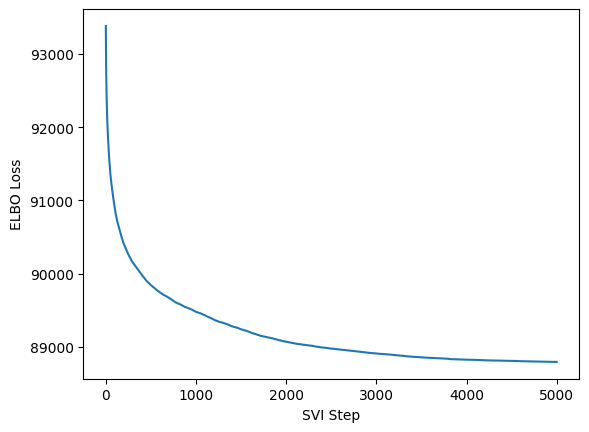

In [226]:
from pyro.infer.autoguide import AutoNormal, AutoDiagonalNormal, AutoContinuous, AutoDelta, AutoMultivariateNormal, AutoLaplaceApproximation, AutoStructured
from pyro.optim import ClippedAdam
from pyro.infer import TraceEnum_ELBO
from pyro.optim import Adam

pyro.clear_param_store()
bnn_cat = BNN_Multi_Layer_SVI(in_dim=16,first_hid_dim=128,sec_hid_dim=128,thir_hid_dim=128,out_dim=2,prior_scale=4,bias_scale=10)
guide = AutoDelta(bnn_cat)
num_steps = 5000

init_lr = 0.001
gamma = 0.01
lrd = gamma ** (1/num_steps)
optim = ClippedAdam({'lr': init_lr, 'lrd': lrd, "betas": (0.95, 0.999)})
# optim = Adam({"lr": 0.01,"betas": (0.95, 0.999)})

svi = SVI(bnn_cat, guide, optim, TraceEnum_ELBO())
losses = []
steps = []

for i in range(num_steps):
    loss = svi.step(x_train,y_train)
    losses.append(loss)
    steps.append(i)
    if i % (num_steps/10) == 0:
        print("[iteration %04d] loss: %.4f" % (i + 1, loss / len(x_train)))

plt.plot(steps,losses)
plt.ylabel("ELBO Loss")
plt.xlabel("SVI Step")
plt.show()

In [227]:
pyro.clear_param_store()
predictive = Predictive(bnn_cat, guide=guide, num_samples=1000, return_sites=["obs","_RETURN"]) # confidence scales inversely w/ num_samples, low num_samp -> high confidence

y_train_1d = [0 if j[0] == 0 else 1 for j in y_train] # [0,1] -> home win -> 0 indicates home win, 1 indicates away
y_test_1d = [0 if j[0] == 0 else 1 for j in y_test]

train_preds = predictive(x_train)['obs'].float().mean(axis=1).float().mean(axis=0)
adj_train_preds = [0 if p[0] < p[1] else 1 for p in train_preds]
print('---TRAINING SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_train_1d,adj_train_preds).ravel())
print(classification_report(y_train_1d,adj_train_preds))

pyro.clear_param_store()
test_preds = predictive(x_test)['obs'].float().mean(axis=1).float().mean(axis=0)
adj_test_preds = [0 if p[0] < p[1] else 1 for p in test_preds]
print('---TEST SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_test_1d,adj_test_preds).ravel())
print(classification_report(y_test_1d,adj_test_preds))

---TRAINING SET---
TN, FP, FN, TP
[4054 1255 1679 3386]
              precision    recall  f1-score   support

           0       0.71      0.76      0.73      5309
           1       0.73      0.67      0.70      5065

    accuracy                           0.72     10374
   macro avg       0.72      0.72      0.72     10374
weighted avg       0.72      0.72      0.72     10374

---TEST SET---
TN, FP, FN, TP
[360 301 361 292]
              precision    recall  f1-score   support

           0       0.50      0.54      0.52       661
           1       0.49      0.45      0.47       653

    accuracy                           0.50      1314
   macro avg       0.50      0.50      0.49      1314
weighted avg       0.50      0.50      0.50      1314



In [223]:
# features_new = maxabs_scale(np.genfromtxt('../NBA/total/samps_feats/2022-2023_nba_features_inj.csv',delimiter=','))
features_new = np.genfromtxt('../NBA/total/samps_feats/2022-2023_nba_features_inj.csv',delimiter=',')
samples_new = np.genfromtxt('../NBA/total/samps_feats/2022-2023_nba_samples_inj.csv',delimiter=',')
bet_data = np.genfromtxt('../NBA/with_bets/2022-2023_season.csv',delimiter=',')

samples_new_1d = [0 if j[0] == 0 else 1 for j in samples_new]

new_x_tens = torch.FloatTensor(features_new)
new_y_tens = torch.FloatTensor(samples_new)

pyro.clear_param_store()

# new_y_pred = predictive(new_x_tens)['obs'].T.float().mean(axis=2)
new_y_pred = predictive(new_x_tens)['obs'].float().mean(axis=1).float().mean(axis=0)
print('PREDICTIONS ON 2022-2023 DATA (SEEN IN TRAINING)')
print(f'max confidence: {new_y_pred.max():.2f}')

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,samples_new_1d,bet_data[1:],one_hot=True, diff_thresh=0.05)
print(f'correct: {correct}')
print(f'guessed: {guessed}')
print(f'risked: {sum(amount)}')
print(f'made: {sum(gained)}')
print(f'ROI: {(sum(gained)/sum(amount)):.2f}\n')

# Test on 2023-2024 data
# features_new = maxabs_scale(np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_features_inj.csv',delimiter=','))
features_new = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_features_inj.csv',delimiter=',')
samples_new = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_samples_inj.csv',delimiter=',')
bet_data = np.genfromtxt('../NBA/with_bets/2023-2024_season.csv',delimiter=',')

samples_new_1d = [0 if j[0] == 0 else 1 for j in samples_new]

new_x_tens = torch.FloatTensor(features_new)
new_y_tens = torch.FloatTensor(samples_new)

pyro.clear_param_store()

# new_y_pred = predictive(new_x_tens)['obs'].T.float().mean(axis=2)
new_y_pred = predictive(new_x_tens)['obs'].float().mean(axis=1).float().mean(axis=0)
print('PREDICTIONS ON 2023-2024 DATA (UNSEEN)')
print(f'max confidence: {new_y_pred.max():.2f}')

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,samples_new_1d,bet_data[1:], one_hot=True, diff_thresh=0.05)
print(f'correct: {correct}')
print(f'guessed: {guessed}')
print(f'risked: {sum(amount)}')
print(f'made: {sum(gained)}')
print(f'ROI: {(sum(gained)/sum(amount)):.2f}')

PREDICTIONS ON 2022-2023 DATA (SEEN IN TRAINING)
max confidence: 0.91
correct: 1272
guessed: 1277
risked: 119647.5234375
made: 62617.00390625
ROI: 0.52

PREDICTIONS ON 2023-2024 DATA (UNSEEN)
max confidence: 0.92
correct: 661
guessed: 1279
risked: 113455.3203125
made: -25223.041015625
ROI: -0.22


# Using consecutive game stats
Previous training used season totals for prediction, making it unlikely (or unrealistic) that models will perform well on test sets. Data from NBA/conc_feats_samps is different as it uses the teams cumulative statistics up to the day of the game for generating features, and has 14 features instead 16. Additionally, the new samples include categorical and continuos options. 

## 1. Categorical samples
We will reuse the same structure before with the new feature set

In [3]:
from torch.nn import LogSoftmax

class BNN_Multi_Layer_SVI(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, first_hid_dim=5, sec_hid_dim=5, 
                 thir_hid_dim=5, four_hid_dim=5, prior_scale=1., bias_scale=10.):
        
        super().__init__()

        self.activation = nn.Tanh()
        self.layer1 = PyroModule[nn.Linear](in_dim, first_hid_dim)
        self.layer2 = PyroModule[nn.Linear](first_hid_dim, sec_hid_dim)
        self.layer3 = PyroModule[nn.Linear](sec_hid_dim, thir_hid_dim)
        self.layer4 = PyroModule[nn.Linear](thir_hid_dim, four_hid_dim)
        self.out = PyroModule[nn.Linear](four_hid_dim, out_dim)

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([in_dim, first_hid_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., bias_scale).expand([first_hid_dim,]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([first_hid_dim, sec_hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., bias_scale).expand([sec_hid_dim,]).to_event(1))
        self.layer3.weight = PyroSample(dist.Normal(0., prior_scale).expand([sec_hid_dim, thir_hid_dim]).to_event(2))
        self.layer3.bias = PyroSample(dist.Normal(0., bias_scale).expand([thir_hid_dim,]).to_event(1))
        self.layer4.weight = PyroSample(dist.Normal(0., prior_scale).expand([thir_hid_dim, four_hid_dim]).to_event(2))
        self.layer4.bias = PyroSample(dist.Normal(0., bias_scale).expand([four_hid_dim,]).to_event(1))
        self.out.weight = PyroSample(dist.Normal(0., prior_scale).expand([four_hid_dim, out_dim]).to_event(2))
        self.out.bias = PyroSample(dist.Normal(0., bias_scale).expand([out_dim,]).to_event(1)) # output bias term

    def forward(self, x, y=None):
        z1 = self.activation(x @ self.layer1.weight + self.layer1.bias)
        z2 = self.activation(z1 @ self.layer2.weight + self.layer2.bias)
        z3 = self.activation(z2 @ self.layer3.weight + self.layer3.bias)
        z4 = self.activation(z3 @ self.layer4.weight + self.layer4.bias)
        z5 = self.activation(z4 @ self.out.weight + self.out.bias) # output layer 

        y_hat = Softmax(dim=1)(z5)

        with pyro.plate("data"):
            obs = pyro.sample("obs", dist.OneHotCategorical(probs=y_hat).to_event(1), obs=y,
                        infer={"enumerate": "parallel"})

        return y_hat

Load features and standardize

In [2]:
from sklearn.preprocessing import minmax_scale, maxabs_scale, StandardScaler
features = np.genfromtxt('../NBA/consec/conc_feats_samps/2017-2023_features_stand.csv',delimiter=',')
samples = np.genfromtxt('../NBA/consec/conc_feats_samps/2017-2023_samples_stand_cat.csv',delimiter=',')
feat_test = StandardScaler().fit_transform((np.genfromtxt('../NBA/consec/conc_feats_samps/2023-2024_nba_features_inj.csv',delimiter=',')))
# feat_test = np.genfromtxt('../NBA/consec/conc_feats_samps/2023-2024_nba_features_inj.csv',delimiter=',')
samp_test = np.genfromtxt('../NBA/consec/conc_feats_samps/2023-2024_samples_cat.csv',delimiter=',')
bet_data_train = np.genfromtxt('../NBA/with_bets/2022-2023_season.csv',delimiter=',')
bet_data_test = np.genfromtxt('../NBA/with_bets/2023-2024_season.csv',delimiter=',')
bet_train = torch.FloatTensor(StandardScaler().fit_transform((np.genfromtxt('../NBA/consec/conc_feats_samps/2022-2023_nba_features_inj.csv',delimiter=','))))
bet_samps_train = np.genfromtxt('../NBA/consec/conc_feats_samps/2022-2023_nba_samples_inj.csv',delimiter=',')

x_train = torch.FloatTensor(features)
x_test = torch.FloatTensor(feat_test)

y_train = torch.Tensor(samples)
y_test = torch.Tensor(samp_test)

y_train_1d = [0 if j[0] == 0 else 1 for j in y_train] # [0,1] -> home win -> 0 indicates home win, 1 indicates away
y_test_1d = [0 if j[0] == 0 else 1 for j in y_test]

Using SVI with an AutoDelta guide

In [ ]:
from pyro.infer.autoguide import AutoNormal, AutoDiagonalNormal, AutoContinuous, AutoDelta, AutoMultivariateNormal, AutoLaplaceApproximation, AutoStructured
from pyro.optim import ClippedAdam
from pyro.infer import TraceEnum_ELBO
from pyro.optim import Adam

from torch.nn import LogSoftmax

pyro.clear_param_store()
bnn_cat = BNN_Multi_Layer_SVI(in_dim=14,first_hid_dim=112,sec_hid_dim=112,thir_hid_dim=112,four_hid_dim=112,out_dim=2,prior_scale=0.75,bias_scale=5)
guide = AutoDelta(bnn_cat)

num_steps = 2000

init_lr = 0.001
gamma = 0.0001
lrd = gamma ** (1/num_steps)
optim = ClippedAdam({'lr': init_lr, 'lrd': lrd, "betas": (0.95, 0.999)})
# optim = Adam({"lr": 0.001,"betas": (0.95, 0.999)})

svi = SVI(bnn_cat, guide, optim, TraceEnum_ELBO())
losses = []
steps = []

for i in range(num_steps):
    loss = svi.step(x_train,y_train_raw)
    losses.append(loss)
    steps.append(i)
    if i % (num_steps/10) == 0:
        print("[iteration %04d] loss: %.4f" % (i + 1, loss / len(x_train)))

plt.plot(steps,losses)
plt.ylabel("ELBO Loss")
plt.xlabel("SVI Step")
plt.show()

In [31]:
pyro.clear_param_store()
predictive = Predictive(bnn_cat, guide=guide, num_samples=500, return_sites=["obs","_RETURN"]) # confidence scales inversely w/ num_samples, low num_samp -> high confidence

pred_performance(predictive,x_train,x_test,y_train,y_test)
make_bets(predictive,bet_data_train,bet_data_test,bet_train,x_test,bet_samps_train,y_test,diff_thresh=0.05,diff_cap=0.25)

---TRAINING SET---
OBS:
TN, FP, FN, TP
[4554  511  739 3086]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      5065
           1       0.86      0.81      0.83      3825

    accuracy                           0.86      8890
   macro avg       0.86      0.85      0.86      8890
weighted avg       0.86      0.86      0.86      8890

RET:
TN, FP, FN, TP
[4563  502  735 3090]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      5065
           1       0.86      0.81      0.83      3825

    accuracy                           0.86      8890
   macro avg       0.86      0.85      0.86      8890
weighted avg       0.86      0.86      0.86      8890

---TEST SET---
OBS:
TN, FP, FN, TP
[502 216 296 300]
              precision    recall  f1-score   support

           0       0.63      0.70      0.66       718
           1       0.58      0.50      0.54       596

    accuracy              

SVI yielded promising results, try simpler architectures for MCMC

In [17]:
from pyro.infer import MCMC, NUTS

pyro.clear_param_store()
bnn_mcmc = BNN_Multi_Layer_SVI(in_dim=14,first_hid_dim=28,sec_hid_dim=56,thir_hid_dim=56,four_hid_dim=28,out_dim=2,prior_scale=0.75,bias_scale=5)
nuts_kernel = NUTS(bnn_mcmc, jit_compile=True)

# mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=200)
mcmc = MCMC(nuts_kernel, num_samples=125)

mcmc.run(x_train, y_train)

Sample: 100%|██████████| 250/250 [1:06:21, 15.93s/it, step size=4.94e-03, acc. prob=0.884]


In [19]:
# get predictions based on posteriors
pyro.clear_param_store()
predictive = Predictive(model=bnn_mcmc, posterior_samples=mcmc.get_samples(), return_sites=['obs','_RETURN'])
pred_performance(predictive,x_train,x_test,y_train,y_test)
make_bets(predictive,bet_data_train,bet_data_test,bet_train,x_test,bet_samps_train,y_test,diff_thresh=0.05,diff_cap=0.25)

---TRAINING SET---
OBS:
TN, FP, FN, TP
[4210  855 1729 2096]
              precision    recall  f1-score   support

           0       0.71      0.83      0.77      5065
           1       0.71      0.55      0.62      3825

    accuracy                           0.71      8890
   macro avg       0.71      0.69      0.69      8890
weighted avg       0.71      0.71      0.70      8890

RET:
TN, FP, FN, TP
[4224  841 1776 2049]
              precision    recall  f1-score   support

           0       0.70      0.83      0.76      5065
           1       0.71      0.54      0.61      3825

    accuracy                           0.71      8890
   macro avg       0.71      0.68      0.69      8890
weighted avg       0.71      0.71      0.70      8890

---TEST SET---
OBS:
TN, FP, FN, TP
[561 157 312 284]
              precision    recall  f1-score   support

           0       0.64      0.78      0.71       718
           1       0.64      0.48      0.55       596

    accuracy              

Although MCMC yielded better confusion matrix results, betting outcomes was worse than SVI. More training and testing needed to find ideal conditions. For now, experiment with continuous samples.

## 2. Continuous samples

Using categorical samples yielded decent results, however continuous samples may provide a better representation of how likely a team is to win a given game. Since we are no longer working with cateogircal samples, the structure of our BNN must change to reflect this. Instead of providing output layer results as the probability for a categorical distribution, we use our output layer to sample from a normal distribution.

In [4]:
from torch.nn import LogSoftmax

class BNN_Cont(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, first_hid_dim=5, sec_hid_dim=5, 
                 thir_hid_dim=5, four_hid_dim=5, prior_scale=1., bias_scale=10.):
        
        super().__init__()

        self.activation = nn.Tanh()
        self.layer1 = PyroModule[nn.Linear](in_dim, first_hid_dim)
        self.layer2 = PyroModule[nn.Linear](first_hid_dim, sec_hid_dim)
        self.layer3 = PyroModule[nn.Linear](sec_hid_dim, thir_hid_dim)
        self.layer4 = PyroModule[nn.Linear](thir_hid_dim, four_hid_dim)
        self.out = PyroModule[nn.Linear](four_hid_dim, out_dim)

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([in_dim, first_hid_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., bias_scale).expand([first_hid_dim,]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([first_hid_dim, sec_hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., bias_scale).expand([sec_hid_dim,]).to_event(1))
        self.layer3.weight = PyroSample(dist.Normal(0., prior_scale).expand([sec_hid_dim, thir_hid_dim]).to_event(2))
        self.layer3.bias = PyroSample(dist.Normal(0., bias_scale).expand([thir_hid_dim,]).to_event(1))
        self.layer4.weight = PyroSample(dist.Normal(0., prior_scale).expand([thir_hid_dim, four_hid_dim]).to_event(2))
        self.layer4.bias = PyroSample(dist.Normal(0., bias_scale).expand([four_hid_dim,]).to_event(1))
        self.out.weight = PyroSample(dist.Normal(0., prior_scale).expand([four_hid_dim, out_dim]).to_event(2))
        self.out.bias = PyroSample(dist.Normal(0., bias_scale).expand([out_dim,]).to_event(1)) # output bias term

    def forward(self, x, y=None):
        z1 = self.activation(x @ self.layer1.weight + self.layer1.bias)
        z2 = self.activation(z1 @ self.layer2.weight + self.layer2.bias)
        z3 = self.activation(z2 @ self.layer3.weight + self.layer3.bias)
        z4 = self.activation(z3 @ self.layer4.weight + self.layer4.bias)
        z5 = self.activation(z4 @ self.out.weight + self.out.bias) # output layer 

        y_hat = Softmax(dim=1)(z5)
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.))

        with pyro.plate("data"):
            obs = pyro.sample("obs", dist.Normal(z5,sigma).to_event(1), obs=y,
                        infer={"enumerate": "parallel"})

        return y_hat

Each sample is of the form [away_pts, home_pts]. We apply a softmax scale to each sample in order to convert point totals to win probabilities.

In [5]:
samples_cont = np.genfromtxt('../NBA/consec/conc_feats_samps/2017-2023_samples_stand_raw.csv',delimiter=',')
samp_cont_test = np.genfromtxt('../NBA/consec/conc_feats_samps/2023-2024_nba_samples_inj.csv',delimiter=',')
y_train_raw = torch.Tensor(samples_cont)
y_test_raw = torch.Tensor(samp_cont_test)
y_train_raw = Softmax(dim=-1)(y_train_raw)
y_test_raw = Softmax(dim=-1)(y_test_raw)

[iteration 0001] loss: 6.6841
[iteration 0201] loss: 1.6014
[iteration 0401] loss: 1.5806
[iteration 0601] loss: 1.5722
[iteration 0801] loss: 1.5687
[iteration 1001] loss: 1.5672
[iteration 1201] loss: 1.5666
[iteration 1401] loss: 1.5664
[iteration 1601] loss: 1.5663
[iteration 1801] loss: 1.5663


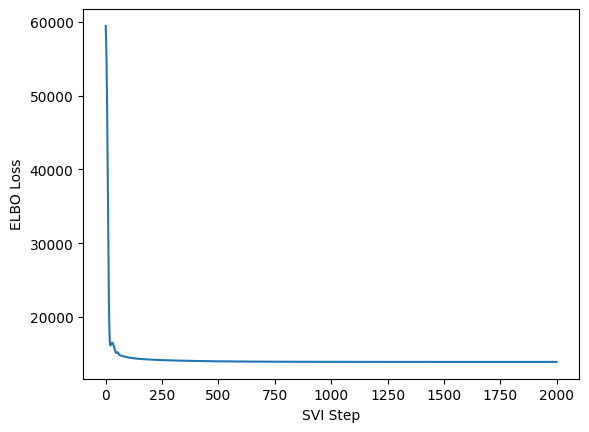

In [87]:
from pyro.infer.autoguide import AutoNormal, AutoDiagonalNormal, AutoContinuous, AutoDelta, AutoMultivariateNormal, AutoLaplaceApproximation, AutoStructured
from pyro.optim import ClippedAdam
from pyro.infer import TraceEnum_ELBO
from pyro.optim import Adam

from torch.nn import LogSoftmax

pyro.clear_param_store()
bnn_cat = BNN_Cont(in_dim=14,first_hid_dim=28,sec_hid_dim=28,thir_hid_dim=28,four_hid_dim=28,out_dim=2,prior_scale=1,bias_scale=7)
guide = AutoDelta(bnn_cat)

num_steps = 2000

init_lr = 0.001
gamma = 0.0001
lrd = gamma ** (1/num_steps)
optim = ClippedAdam({'lr': init_lr, 'lrd': lrd, "betas": (0.95, 0.999)})

svi = SVI(bnn_cat, guide, optim, TraceEnum_ELBO())
losses = []
steps = []

for i in range(num_steps):
    loss = svi.step(x_train,y_train_raw)
    losses.append(loss)
    steps.append(i)
    if i % (num_steps/10) == 0:
        print("[iteration %04d] loss: %.4f" % (i + 1, loss / len(x_train)))

plt.plot(steps,losses)
plt.ylabel("ELBO Loss")
plt.xlabel("SVI Step")
plt.show()

In [88]:
from util.client import Nba_Season, kelly, BNN_kelly, make_bets, pred_performance
pyro.clear_param_store()
predictive = Predictive(bnn_cat, guide=guide, num_samples=500, return_sites=["obs","_RETURN"]) # confidence scales inversely w/ num_samples, low num_samp -> high confidence

pred_performance(predictive,x_train,x_test,y_train,y_test,use_ret=False)
make_bets(predictive,bet_data_train,bet_data_test,bet_train,x_test,bet_samps_train,y_test,diff_thresh=0.05,diff_cap=0.25,use_ret=False,categorical=False)

---TRAINING SET---
OBS:
TN, FP, FN, TP
[3994 1071 1988 1837]
              precision    recall  f1-score   support

           0       0.67      0.79      0.72      5065
           1       0.63      0.48      0.55      3825

    accuracy                           0.66      8890
   macro avg       0.65      0.63      0.63      8890
weighted avg       0.65      0.66      0.65      8890

---TEST SET---
OBS:
TN, FP, FN, TP
[578 140 324 272]
              precision    recall  f1-score   support

           0       0.64      0.81      0.71       718
           1       0.66      0.46      0.54       596

    accuracy                           0.65      1314
   macro avg       0.65      0.63      0.63      1314
weighted avg       0.65      0.65      0.63      1314

PREDICTIONS ON 2022-2023 DATA (SEEN IN TRAINING)
Using OBS:
max confidence: 0.90
correct: 409
guessed: 635
risked: 22994.826171875
made: 425.5428161621094
ROI: 0.02

PREDICTIONS ON 2023-2024 DATA (UNSEEN)
Using OBS:
max confidence: 

Accuracy and confidence seem better with continuous samples, however better returns do not reflect these improvements.

In [6]:
from pyro.infer import MCMC, NUTS

pyro.clear_param_store()
bnn_mcmc = BNN_Cont(in_dim=14,first_hid_dim=28,sec_hid_dim=28,thir_hid_dim=28,four_hid_dim=28,out_dim=2,prior_scale=0.75,bias_scale=5)
nuts_kernel = NUTS(bnn_mcmc, jit_compile=True)

# mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=200)
mcmc = MCMC(nuts_kernel, num_samples=50)

mcmc.run(x_train, y_train_raw)

Warmup:   0%|          | 0/100 [00:00, ?it/s]

Sample: 100%|██████████| 100/100 [19:16, 11.56s/it, step size=7.17e-04, acc. prob=0.946]


In [12]:
pyro.clear_param_store()
predictive = Predictive(model=bnn_mcmc, posterior_samples=mcmc.get_samples(), return_sites=['obs','_RETURN'])
pred_performance(predictive,x_train,x_test,y_train,y_test,categorical=False)
make_bets(predictive,bet_data_train,bet_data_test,bet_train,x_test,bet_samps_train,y_test,diff_thresh=0.05,diff_cap=0.25,categorical=False)

---TRAINING SET---
OBS:
TN, FP, FN, TP
[4670  395  845 2980]
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      5065
           1       0.88      0.78      0.83      3825

    accuracy                           0.86      8890
   macro avg       0.86      0.85      0.86      8890
weighted avg       0.86      0.86      0.86      8890

RET:
TN, FP, FN, TP
[4681  384  861 2964]
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      5065
           1       0.89      0.77      0.83      3825

    accuracy                           0.86      8890
   macro avg       0.86      0.85      0.85      8890
weighted avg       0.86      0.86      0.86      8890

---TEST SET---
OBS:
TN, FP, FN, TP
[497 221 323 273]
              precision    recall  f1-score   support

           0       0.61      0.69      0.65       718
           1       0.55      0.46      0.50       596

    accuracy              

MCMC can yield over 100% confidence when overfitting, more exploration needed in architecture and training.

## Trying different normalization technique
Improving quality of data could be useful, we will explore the performance of a simple BNN on unnormalized, minmax norm, maxabs norm

### Unnormalized
First, we will construct a new unnormalized features file from 2014/2015 to 2022/2023

In [4]:
from sklearn.preprocessing import minmax_scale, maxabs_scale
features = []
feat_minmax = []
feat_maxabs = []
samples = []
start = 2014

while start < 2023:
    if start == 2018: # this year is missing and wont populate thru scraper!!
        start += 1
        continue

    curr_feats = np.genfromtxt('../NBA/total/samps_feats/{start}-{end}_nba_features_inj.csv'.format(start=start,end=start+1),delimiter=',')
    curr_samps = np.genfromtxt('../NBA/total/samps_feats/{start}-{end}_nba_samples_inj.csv'.format(start=start,end=start+1),delimiter=',')
    feat_minmax.extend(minmax_scale(curr_feats))
    feat_maxabs.extend(maxabs_scale(curr_feats))
    features.extend(curr_feats)
    samples.extend(curr_samps)
    start += 1


np.savetxt('../NBA/total/samps_feats/2015-2023_nba_features_unnorm.csv', features, delimiter=',')
np.savetxt('../NBA/total/samps_feats/2015-2023_nba_samples.csv', samples, delimiter=',')
np.savetxt('../NBA/total/samps_feats/2015-2023_nba_features_minmax.csv', features, delimiter=',')
np.savetxt('../NBA/total/samps_feats/2015-2023_nba_features_maxabs.csv', features, delimiter=',')

In [5]:
feat_test = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_features_inj.csv',delimiter=',') # unnormalized
samp_test = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_samples_inj.csv',delimiter=',')

x_train = torch.FloatTensor(features)
x_test = torch.FloatTensor(feat_test)
y_train = torch.FloatTensor(samples)
y_test = torch.FloatTensor(samp_test)

C:\Users\andre\AppData\Local\Temp\ipykernel_15840\2636246682.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  x_train = torch.FloatTensor(features)


In [6]:
from pyro.infer import MCMC, NUTS

x_train = torch.FloatTensor(feat_maxabs)
x_test = torch.FloatTensor(maxabs_scale(feat_test))
y_train = torch.FloatTensor(samples)
y_test = torch.FloatTensor(samp_test)

model = BNN(in_dim=16,hid_dim=16,out_dim=2)

pyro.set_rng_seed(1)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

mcmc.run(x_train, y_train.T)

Sample: 100%|██████████| 100/100 [01:35,  1.05it/s, step size=4.07e-02, acc. prob=0.788]


In [7]:
# get predictions based on posteriors
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples(), return_sites=['obs','_RETURN'])

train_preds = predictive(x_train)['obs'].T.float().mean(axis=1)
test_preds = predictive(x_test)['obs'].T.float().mean(axis=1)

adj_train_preds = [0 if p < 0.5 else 1 for p in train_preds]
adj_test_preds = [0 if p < 0.5 else 1 for p in test_preds]
y_train_1d = [0 if j[0] == 0 else 1 for j in y_train] # [0,1] -> [away,home] -> 0 indicates home win, 1 indicates away
y_test_1d = [0 if j[0] == 0 else 1 for j in y_test]

print('---TRAINING SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_train_1d,adj_train_preds).ravel())
print(classification_report(y_train_1d,adj_train_preds))
print('---TEST SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_test_1d,adj_test_preds).ravel())
print(classification_report(y_test_1d,adj_test_preds))

---TRAINING SET---
TN, FP, FN, TP
[2384 2925 2191 2874]
              precision    recall  f1-score   support

           0       0.52      0.45      0.48      5309
           1       0.50      0.57      0.53      5065

    accuracy                           0.51     10374
   macro avg       0.51      0.51      0.51     10374
weighted avg       0.51      0.51      0.51     10374

---TEST SET---
TN, FP, FN, TP
[296 365 267 386]
              precision    recall  f1-score   support

           0       0.53      0.45      0.48       661
           1       0.51      0.59      0.55       653

    accuracy                           0.52      1314
   macro avg       0.52      0.52      0.52      1314
weighted avg       0.52      0.52      0.52      1314



In [8]:
# Get 2022-2023 game data and betting information
features_new = maxabs_scale(np.genfromtxt('../NBA/total/samps_feats/2022-2023_nba_features_inj.csv',delimiter=','))
samples_new = np.genfromtxt('../NBA/total/samps_feats/2022-2023_nba_samples_inj.csv',delimiter=',')
bet_data = np.genfromtxt('../NBA/with_bets/2022-2023_season.csv',delimiter=',')

samples_new_1d = [0 if j[0] == 0 else 1 for j in samples_new]

new_x_tens = torch.FloatTensor(features_new)
new_y_tens = torch.FloatTensor(samples_new)

new_predictive = Predictive(model=model, posterior_samples=mcmc.get_samples(),return_sites=("obs","_RETURN"))
new_y_pred = new_predictive(new_x_tens)['obs'].T.float().mean(axis=1)

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,samples_new_1d,bet_data[1:])
print(correct)
print(guessed)
print(sum(gained))

# Test on 2023-2024 data
features_new = maxabs_scale(np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_features_inj.csv',delimiter=','))
samples_new = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_samples_inj.csv',delimiter=',')
bet_data = np.genfromtxt('../NBA/with_bets/2023-2024_season.csv',delimiter=',')

samples_new_1d = [0 if j[0] == 0 else 1 for j in samples_new]

new_x_tens = torch.FloatTensor(features_new)
new_y_tens = torch.FloatTensor(samples_new)

new_predictive = Predictive(model=model, posterior_samples=mcmc.get_samples(),return_sites=("obs","_RETURN"))
new_y_pred = new_predictive(new_x_tens)['obs'].T.float().mean(axis=1)

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,samples_new_1d,bet_data[1:])
print(correct)
print(guessed)
print(sum(gained))

40
106
tensor(-746.6345)
49
118
tensor(-704.2104)
